# Caso de estudio: Reconocimiento de Rostros

_Autor:_ [Luis Carlos Padierna](https://scholar.google.com/citations?user=JhchZkQAAAAJ&hl=es&oi=ao)

_Editado por:_ Edwin Bedolla

En este documento se presenta un problema de clasificación donde se implementarán las Máquinas de Soporte Vectorial (MSV) exclusivamente para conocer sus ventajas en tareas complejas. A continuación se presenta una descripción breve del conjunto de datos y las características de este, después se comentará la implementación de los algoritmos.

## _Labeled Faces in the Wild_

Este conjunto de datos consta de imágenes de presidentes y gente famosa en diferentes aspectos, felices, tristes, enojados, entre muchas otras cosas. Para citar el [sitio oficial:](http://vis-www.cs.umass.edu/lfw/)

> [...] a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. More details can be found in the technical report below.

Como se menciona, el conjunto de datos consta de imágenes, por lo que se tendrá que manipular los datos de alguna forma para extraer un conjunto de datos como se ha estado manejando hasta ahora. Para este conjunto de datos **no** se tomarán en cuenta todas las imágenes, sino un subconjunto de estas tal que cada persona tenga mínimo 60 imágenes, esto para evitar que exista un desbalanceo de clases al momento de realizar la predicción.

In [4]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

sns.set()

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


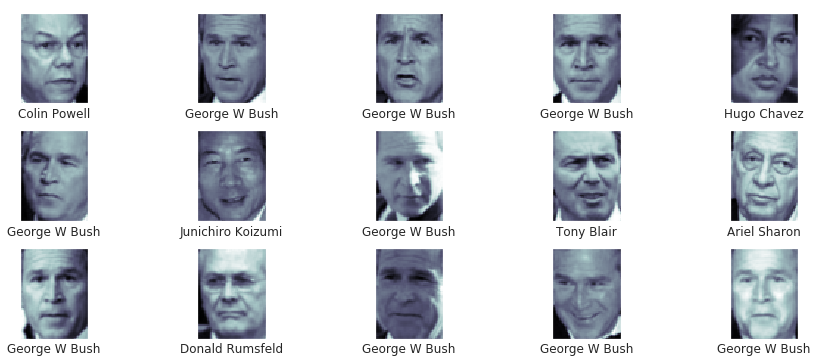

In [5]:
# Importar solamente aquellas personas que tengan mínimo 60 imágenes dentro
# del conjunto de datos
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

# Mostrar algunas de las imágenes
fig, ax = plt.subplots(3, 5, figsize=(14, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])
    fig.subplots_adjust(wspace=1.5, hspace=0.3)

## Sobre la exploración de los datos

**Siempre** se deben explorar los datos; si pertenecen a imágenes, mostrarlas; si son datos, graficarlos; si es texto, leer un subconjunto de este. Es fundamental explorar los datos, conocer con qué se está trabajando. Este tipo de exploraciones se estudian y detallan con rigor en la sección _Procesamiento de Datos_ dentro de este repositorio.

En este caso se observa que son imágenes sin color, pero tampoco son en blanco y negro específicamente. Además, la cantidad de datos es enorme con 62x47 características por imagen, lo cual es algo muy importante a tomar en cuenta porque aunque las MSV pueden operar correctamente en espacios con alta dimensión, no se recomienda trabajar con tal alta dimensión debido a la [maldición de la dimensionalidad](https://es.wikipedia.org/wiki/Maldici%C3%B3n_de_la_dimensi%C3%B3n).

Se empleará el método de [_Análisis de Componentes Principales_](https://en.wikipedia.org/wiki/Principal_component_analysis) que permite la reducción de dimensionalidad del conjunto de datos en cuestión; este algoritmo se trata en la sección _Procesamiento de Datos_ dentro de este repositorio, y aquí solamente se emplea, por lo que se remite al lector a explorar el resto del repositorio.

In [27]:
# Emplea PCA para reducir a 150 la dimensión del conjunto de datos
pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver="randomized")
# Y transformar los datos para reducir la dimensión
X_red = pca.fit_transform(faces.data)
print("Nuevo tamaño: {}".format(X_red.shape))

Nuevo tamaño: (1348, 150)


In [12]:
# Crear la MSV pero no se debe entrenar, primero se ajustarán los parámetros
svc = SVC(kernel="rbf", class_weight="balanced")

In [13]:
# Como siempre, separa el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_red, faces.target, 
                                                    test_size=0.25, random_state=42)
print("X_train: {}\nX_test: {}".format(len(X_train), len(X_test)))
print("y_train: {}\ny_test: {}".format(len(y_train), len(y_test)))

X_train: 1011
X_test: 337
y_train: 1011
y_test: 337


## Validación cruzada

Se comentó en el documento de teoría que las MSV deben siempre encontrar un _espacio auxiliar_ donde las clases son linealmente separables, en este caso se opta por un espacio donde el _kernel_ de base radial es el indicado. Sin embargo, se deben ajustar los parámetro con la tolerancia de error en la _frontera de decisión_ así como el parámetro intrínseco del _kernel_ de base radial. Para esto se emplea la técnica de **validación cruzada** donde se tiene un conjunto de _posibles parámetros_ que pueden ser los indicados para que la MSV tenga el mejor desempeño, esta técnica entrenará muchos modelos al mismo tiempo para obtener aquel con la mejor precisión de clasificación de todos.

In [21]:
# Entrenar MSV con búsqueda de paráemetros y validación cruzada
param_grid = {"C": [1, 5, 10, 50], "gamma": [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid, cv=10, n_jobs=-2, iid=False)
# Mostrar el tiempo de ejecución y el mejor modelo encontrado
%time grid.fit(X_train, y_train)
print(grid.best_estimator_)

CPU times: user 618 ms, sys: 34.8 ms, total: 652 ms
Wall time: 14.7 s
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


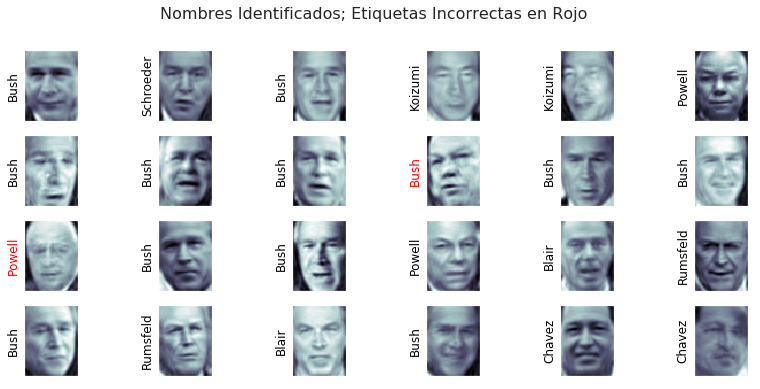

In [26]:
# Ahora que se ha encontrado la mejor MSV se emplea para la clasificación
model = grid.best_estimator_
resultado = model.predict(X_test)

# Verificar la parte de la predicción
fig, ax = plt.subplots(4, 6, figsize=(14, 6))
for i, axi in enumerate(ax.flat):
    datos_reales_test = pca.inverse_transform(X_test)
    axi.imshow(datos_reales_test[i].reshape(62, 47),
               cmap="bone")
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[resultado[i]].split()[-1],
        color="black" if resultado[i] == y_test[i] else "red")
    fig.suptitle("Nombres Identificados; Etiquetas Incorrectas en Rojo", size=16)

In [23]:
print(classification_report(y_test, resultado, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.60      0.72        15
     Colin Powell       0.82      0.87      0.84        68
  Donald Rumsfeld       0.96      0.71      0.81        31
    George W Bush       0.76      0.95      0.85       126
Gerhard Schroeder       0.94      0.70      0.80        23
      Hugo Chavez       1.00      0.60      0.75        20
Junichiro Koizumi       1.00      0.67      0.80        12
       Tony Blair       0.92      0.81      0.86        42

        micro avg       0.83      0.83      0.83       337
        macro avg       0.91      0.74      0.80       337
     weighted avg       0.85      0.83      0.83       337



Text(89.18, 0.5, 'Etiquetas MSV')

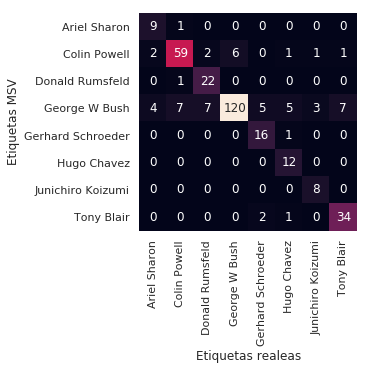

In [25]:
mat = confusion_matrix(y_test, resultado)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, 
            xticklabels=faces.target_names, 
            yticklabels=faces.target_names)
plt.xlabel("Etiquetas reales")
plt.ylabel("Etiquetas MSV")

En general, las MSV tienen un buen desempeño en este conjunto de datos, quizás con algún otro tipo de _kernel_ sea posible mejorar la predicción, emplear alguna técnica de balanceo de clases entre otro tipo de técnicas de procesamiento de datos.

La matriz de confusión es un excelente indicador de que el modelo opera de forma adecuada pero no se podría garantizar que es el mejor algoritmo que existe. De hecho se puede observar en el reporte de clasificación que este modelo no tiene buena _retención_ de características, esto es que cuando observa una imagen no sabe por sí misma a qué persona pertenece, necesita forzosamente observar otra imagen para realizar la comparación. Esto no siempre es deseable, pues se espera que el modelo haya podido generalizar correctamente todas las características sin tener que observar los datos de nuevo.